# DEEP LEARNING IE

## Alur proses BiLSTM + CBOW

---

### *(Dataset: PN-Purwodadi)*

---


### 🧩 [1] Import Library & Setup Environment
- Import: `TensorFlow`, `Keras`, `Pandas`, `NumPy`, `NLTK`, dll  
- Mount **Google Drive** (jika di Colab)  
- Install dependensi tambahan:  
  `keras-contrib`, `sklearn-crfsuite`

---

### 📂 [2] Load Dataset
- Membaca file: **DatasetPos-Pidana200.csv**  
- Menampilkan informasi dasar dataset  
- Menentukan kolom teks dan label  

---

### 🧹 [3] Preprocessing Teks
- Lowercasing (semua huruf kecil)  
- Menghapus tanda baca, angka, simbol  
- Tokenisasi (memecah teks menjadi kata)  
- Menghapus *stopwords* (kata umum yang tidak bermakna)  
- Membuat daftar kata unik (*vocabulary*)  
- **Padding sequence** agar panjang teks seragam (`MAX_LEN`)

---

### 🧠 [4] Pembuatan Embedding CBOW
- Menggunakan pendekatan **Continuous Bag of Words (CBOW)**  
- Membuat representasi vektor rata-rata dari konteks kata  
- Menyimpan hasil embedding ke dalam matrix  
- Embedding digunakan sebagai input ke model **BiLSTM**

---

### 🏗️ [5] Membangun Model BiLSTM
- **Input Layer:** Embedding Layer  
- **Hidden Layer:** Bidirectional LSTM  
- **Regularization:** Dropout Layer (mencegah overfitting)  
- **Dense Layer:** Fully Connected  
- **Output Layer:** Aktivasi `sigmoid` / `softmax` untuk klasifikasi  

---

### 🔧 [6] Kompilasi & Pelatihan Model
- **Loss Function:** `binary_crossentropy` / `categorical_crossentropy`  
- **Optimizer:** `Adam`  
- **Metric:** `accuracy`  
- **Training:**  
  `model.fit(X_train, y_train, validation_split=0.2)`

---

### 📊 [7] Evaluasi & Visualisasi
- Menghitung *accuracy* dan *loss*  
- Plot grafik *loss* dan *accuracy* per epoch  
- Menampilkan **Confusion Matrix** & **Classification Report**  
- Menyimpan model dan tokenizer  

---




In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
from __future__ import absolute_import, division, print_function, unicode_literals

! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done


In [100]:
print(tf.__version__)

2.19.0


In [101]:
BATCH_SIZE = 64  # Number of examples used in each iteration
EPOCHS = 50 # Number of passes through entire dataset
MAX_LEN = 100  # Max length of review (in words)
EMBEDDING = 100  # Dimension of word embedding vector

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# data = pd.read_csv("/kaggle/input/dataset-pos-pidana-baru/DatasetPos-Pidana200.csv", encoding="latin1")
data = pd.read_csv("/content/drive/MyDrive/Information Extraction/PWD-fix.csv", encoding="latin1")
# data = pd.read_csv("/kaggle/input/dataset-pidana-baru/Dataset-Pidana200 (1).csv")

# data['word'] = data['word'].str.lower()
data['word'] = data['word'].replace(to_replace ='\d+', value = '<\g<0>>', regex = True).replace(to_replace ='[0-9]', value = 'X', regex = True)
data = data.fillna(method="ffill")

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3138805690.py:11: SyntaxWarning: invalid escape sequence '\d'
  data['word'] = data['word'].replace(to_replace ='\d+', value = '<\g<0>>', regex = True).replace(to_replace ='[0-9]', value = 'X', regex = True)
/tmp/ipython-input-3138805690.py:11: SyntaxWarning: invalid escape sequence '\g'
  data['word'] = data['word'].replace(to_replace ='\d+', value = '<\g<0>>', regex = True).replace(to_replace ='[0-9]', value = 'X', regex = True)
/tmp/ipython-input-3138805690.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


In [103]:
data

,doc,sentence,word,prev,next,tag
0,doc:0,sentence: 000003,<XX>/Pid.B/<XXXX>/PN,.,Pwd,B_VERN
1,doc:0,sentence: 000004,Pwd,66/Pid.B/2018/PN,Sabar,I_VERN
2,doc:0,sentence: 000007,Sabar,Pwd,Bin,B_DEFN
3,doc:0,sentence: 000008,Bin,Sabar,Sawijo,I_DEFN
4,doc:0,sentence: 000009,Sawijo,Bin,TUNTUTAN,I_DEFN
...,...,...,...,...,...,...
15602,doc:216,sentence: 020826,"Noviana,",Deden,S.H.,I_PROS
15603,doc:216,sentence: 020827,S.H.,"Noviana,",Terdakwa,I_PROS
15604,doc:216,sentence: 020830,Terdakwa,S.H.,menghadap,B_ADVO
15605,doc:216,sentence: 020831,menghadap,Terdakwa,sendiri,I_ADVO


In [104]:
data.groupby('tag').count()

,doc,sentence,word,prev,next
tag,,,,,
B_ADVO,216,216,216,216,216
B_ARTV,220,220,220,220,220
B_CRIA,216,216,216,216,216
B_DEFN,248,248,248,248,248
B_JUDP,216,216,216,216,216
B_JUG,327,327,327,327,327
B_PENA,151,151,151,151,151
B_PROS,216,216,216,216,216
B_PUNI,230,230,230,230,230


In [105]:
words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words)
n_words

1728

In [106]:
tags = list(set(data["tag"].values))
n_tags = len(tags)
n_tags

25

## Group Per Kalimat

In [107]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

# class DocGetter(object):

#     def __init__(self, data):
#         self.n_doc = 1
#         self.data = data
#         self.empty = False
#         agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
#                                                            s["tag"].values.tolist())]
#         self.grouped = self.data.groupby("doc").apply(agg_func)
#         self.docs = [s for s in self.grouped]

#     def get_next(self):
#         try:
#             d = self.grouped[self.n_doc]
#             self.n_doc += 1
#             return d
#         except:
#             return None

In [108]:
# # getter = DocGetter(data)
# # docs = getter.docs
getter = SentenceGetter(data)
sentences = getter.sentences

/tmp/ipython-input-1008250215.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("sentence").apply(agg_func)


In [109]:
sentences[500]

[('Mulyono', 'I_ADVO')]

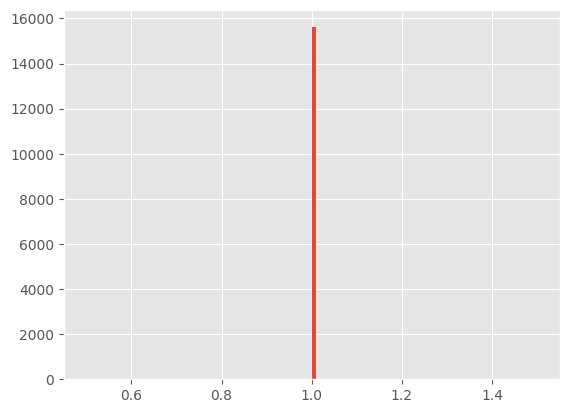

In [110]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.hist([len(s) for s in sentences], bins=100)
plt.show()

# CBOW

In [111]:
!pip install gensim

In [112]:
from gensim.models import Word2Vec
sentences_words = [[w[0] for w in s] for s in sentences]
cbow_model = Word2Vec(sentences_words, vector_size=10, window=5, min_count=1, sg=0)

In [113]:
tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {i: w for w, i in tag2idx.items()}

In [114]:
def get_word_embedding(word):
    if word in cbow_model.wv:
        return cbow_model.wv[word]
    else:
        return np.zeros(cbow_model.vector_size)

In [115]:
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
X = [[get_word_embedding(w[0]) for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", dtype='float32', value=np.zeros(cbow_model.vector_size))

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [116]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, shuffle=False)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((12485, 100, 10), (3122, 100, 10), (12485, 100, 26), (3122, 100, 26))

In [117]:
cbow_model.vector_size

10

In [118]:
from keras import Model
from keras import optimizers
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D, Reshape
from keras.utils import plot_model

# input = Input(shape=(MAX_LEN,)) #Asli
input = Input(shape=(MAX_LEN, cbow_model.vector_size))

# model = Embedding(input_dim=n_words, output_dim=10, input_length=5)(input)
model = Dropout(0.1)(input)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 100, 200)       │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 100, 26)        │         5,226 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,026 (367.29 KB)

 Trainable params: 94,026 (367.29 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
input

<KerasTensor shape=(None, 100, 10), dtype=float32, sparse=False, ragged=False, name=keras_tensor_12>

## Visualisasi Model

In [120]:
! pip install pydot graphviz

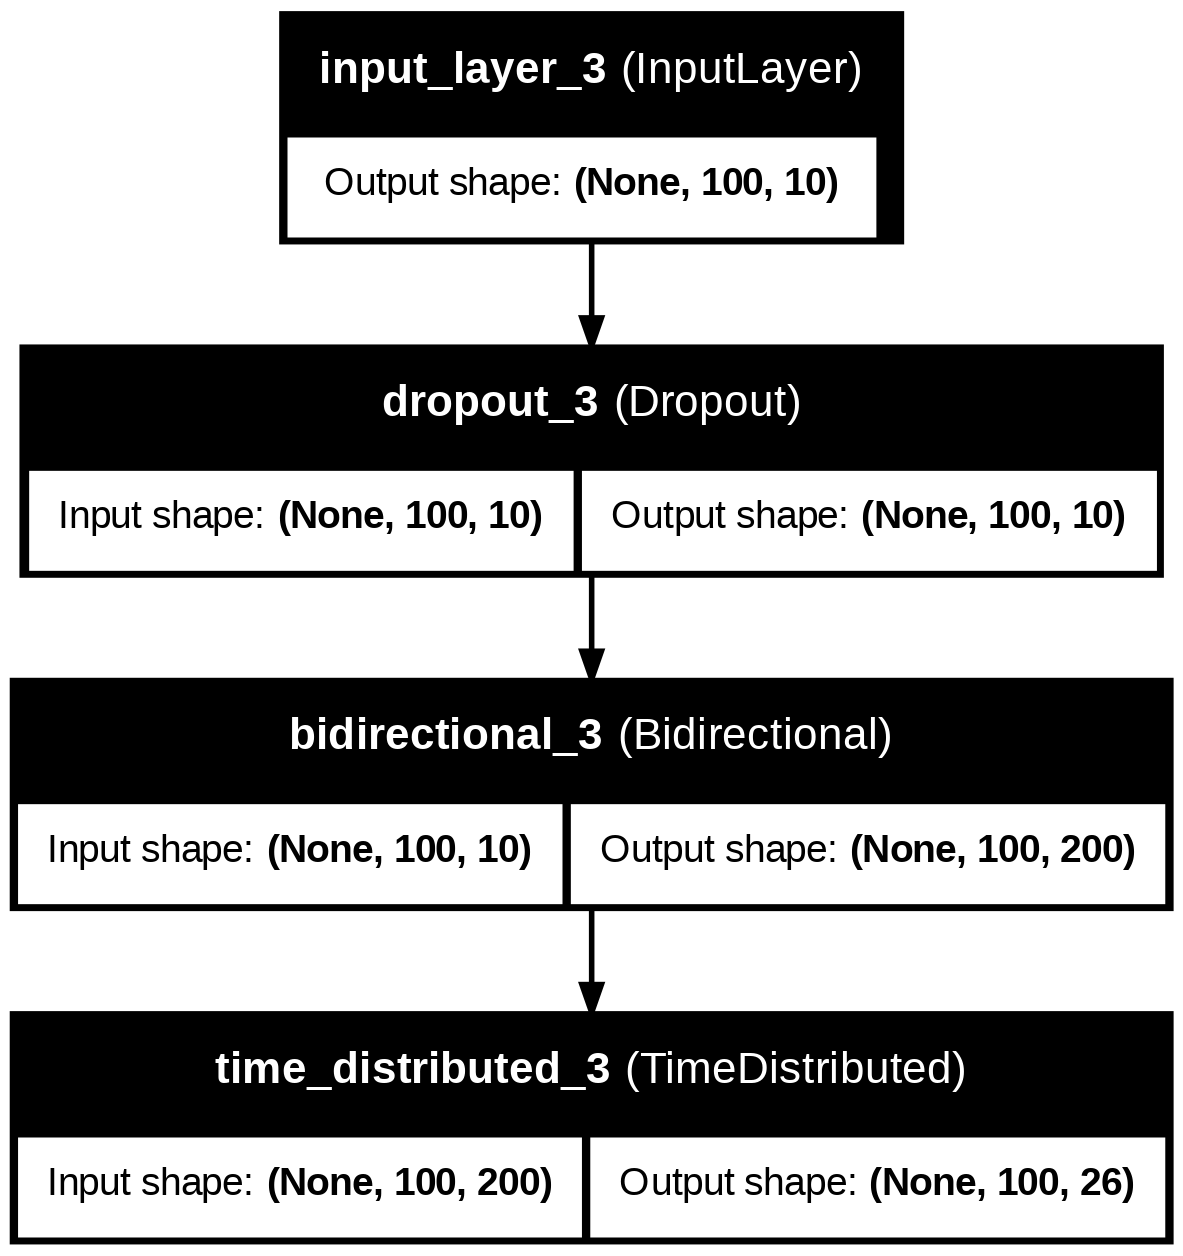

In [121]:
from keras.utils import plot_model

plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image

image_path = 'model_visualization.png'
display(Image(filename=image_path))
with open(image_path, 'rb') as img_file:
    img_data = img_file.read()

In [122]:
history = model.fit(np.array(X_tr).astype(int),
                    np.array(y_tr).astype(int),
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 154s 696ms/step - accuracy: 0.9587 - loss: 0.4956 - val_accuracy: 0.9910 - val_loss: 0.0381
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 114s 649ms/step - accuracy: 0.9909 - loss: 0.0355 - val_accuracy: 0.9910 - val_loss: 0.0318
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 140s 637ms/step - accuracy: 0.9909 - loss: 0.0304 - val_accuracy: 0.9910 - val_loss: 0.0301
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 139s 622ms/step - accuracy: 0.9910 - loss: 0.0292 - val_accuracy: 0.9912 - val_loss: 0.0296
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 123s 702ms/step - accuracy: 0.9914 - loss: 0.0289 - val_accuracy: 0.9914 - val_loss: 0.0295
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 112s 639ms/step - accuracy: 0.9914 - loss: 0.0287 - val_accuracy: 0.9912 - val_loss: 0.0293
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 116s 658ms/step - accuracy: 0.9914 - loss: 0.0285 - val_accuracy: 0.9914 - val_loss: 0.0294
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 116s 657ms/step - accuracy: 0.9914 -

In [123]:
import torch

In [124]:
path = '/content/drive/MyDrive/Information Extraction/DEEP LEARNING/model-BiLSTM-PN-PWD.pth'
torch.save(model, path)

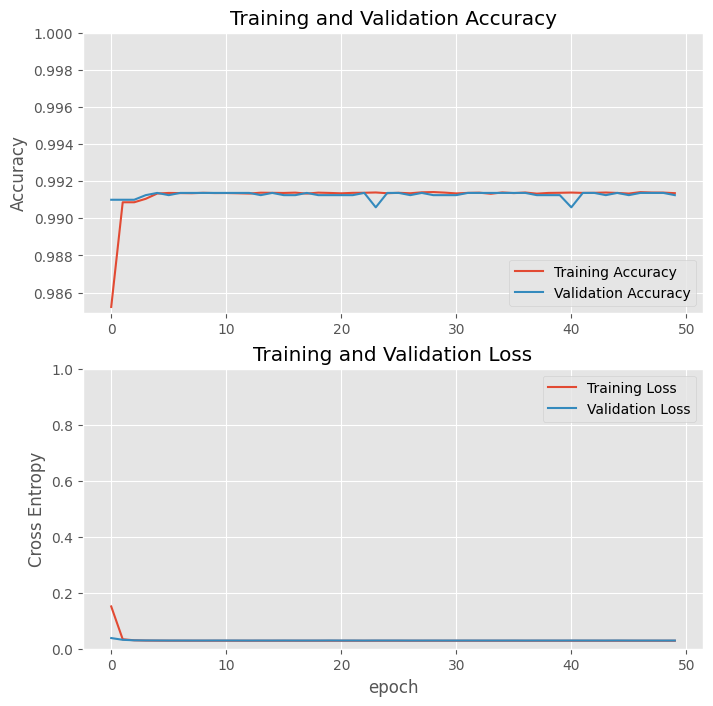

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [134]:
eve = model.predict(X_te)

98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


In [135]:
y_pred = np.argmax(eve, axis=-1)
y_test_true = np.argmax(y_te, -1)

# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [136]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

m = MultiLabelBinarizer().fit(y_test_true)
print("Precision Score: {}".format(precision_score(m.transform(y_test_true), m.transform(y_pred), average="macro")))
print("Recall Score   : {}".format(recall_score(m.transform(y_test_true), m.transform(y_pred), average="macro")))
print("F1-score Score : {}".format(f1_score(m.transform(y_test_true), m.transform(y_pred), average="macro")))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision Score: 0.04640614990390775
Recall Score   : 0.08
F1-score Score : 0.051043622308117056


In [137]:
from sklearn.metrics import classification_report
def c_report(y_pred, y_true):
  # Menggabungkan elemen-elemen array menjadi satu list
  y_pred_flat = [item for sublist in y_pred for item in sublist]
  y_true_flat = [item for sublist in y_true for item in sublist]
  report = classification_report(y_pred_flat, y_true_flat)
  return report

In [138]:
report = c_report(y_pred, y_test_true)
print(report)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      B_ADVO       0.00      0.00      0.00         0
      B_ARTV       0.00      0.00      0.00         0
      B_CRIA       0.00      0.00      0.00         0
      B_DEFN       0.00      0.00      0.00         0
      B_JUDP       0.00      0.00      0.00         0
       B_JUG       0.00      0.00      0.00         0
      B_PENA       0.00      0.00      0.00         0
      B_PROS       0.00      0.00      0.00         0
      B_PUNI       0.00      0.00      0.00         0
      B_REGI       0.00      0.00      0.00         0
      B_TIMV       0.00      0.00      0.00         0
      B_VERN       0.00      0.00      0.00         0
      I_ADVO       0.00      0.00      0.00         0
      I_ARTV       0.00      0.00      0.00         0
      I_CRIA       0.00      0.00      0.00         0
      I_DEFN       0.00      0.00      0.00         0
      I_JUDP       0.00      0.00      0.00         0
       I_JUG       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


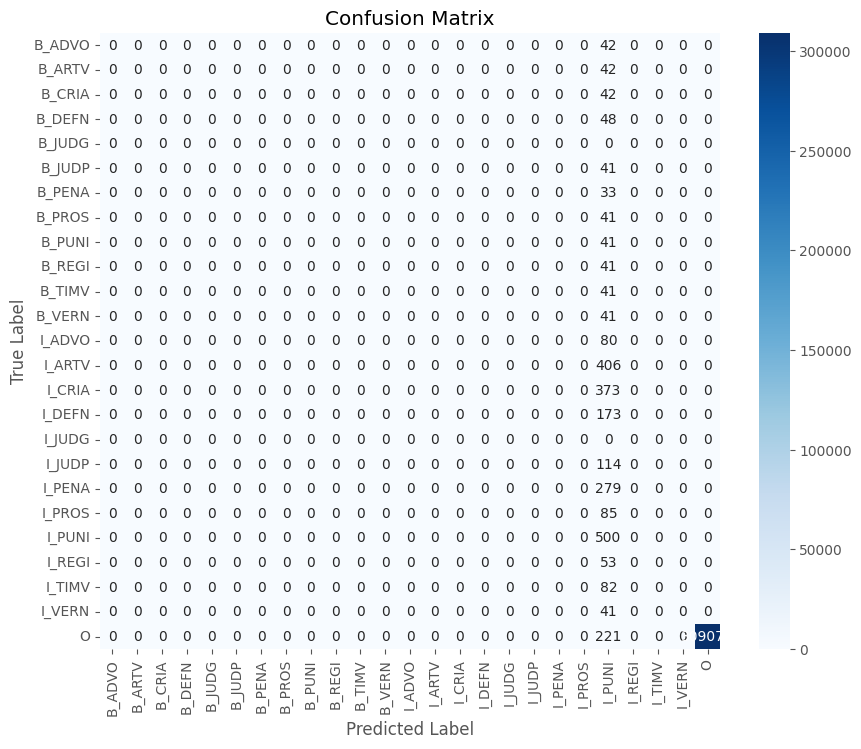

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Definisi class_names (sesuaikan dengan label yang sesuai dalam datasetmu)
class_names = ['B_ADVO', 'B_ARTV', 'B_CRIA', 'B_DEFN', 'B_JUDG', 'B_JUDP', 'B_PENA', 'B_PROS', 'B_PUNI', 'B_REGI', 'B_TIMV', 'B_VERN', 'I_ADVO', 'I_ARTV', 'I_CRIA', 'I_DEFN', 'I_JUDG', 'I_JUDP', 'I_PENA', 'I_PROS', 'I_PUNI', 'I_REGI', 'I_TIMV', 'I_VERN', 'O']

conf_mat = confusion_matrix([item for sublist in y_test_true for item in sublist],
                            [item for sublist in y_pred for item in sublist],
                            labels=class_names)
# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [132]:
def prepare_input(words, cbow_model, max_len):
    X = [[get_word_embedding(word) for word in words]]
    X = pad_sequences(maxlen=max_len, sequences=X, padding="post", dtype='float32', value=np.zeros(cbow_model.vector_size))
    return np.array(X)
def predict_single_word(model, X_new, cbow_model, max_len, idx2tag):
    y_pred = model.predict(X_new)
    y_pred = np.argmax(y_pred, axis=-1)
    predicted_tag_idx = y_pred[0][0]
    return idx2tag[predicted_tag_idx]
def predict_tags(model, words, cbow_model, max_len, idx2tag):
    X_new = prepare_input(words, cbow_model, max_len)
    y_pred = model.predict(X_new)
    y_pred = np.argmax(y_pred, axis=-1)
    predictions = [idx2tag[idx] for idx in y_pred[0]]
    return predictions

In [133]:
new_word = 'pwd'
X_new = prepare_input(new_word, cbow_model, MAX_LEN)
predicted_tag = predict_single_word(model, X_new, cbow_model, MAX_LEN, idx2tag)
print(f"The predicted tag for '{new_word}' is '{predicted_tag}'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
The predicted tag for 'pwd' is 'I_PUNI'


## Modifikasi Code

In [150]:
!pip install gradio

In [153]:
# 1. Install/Import semua yang dibutuhkan
!pip install gradio
import gradio as gr
import re
import numpy as np
import functools
from tensorflow.keras.utils import pad_sequences

# 2. Definisikan ulang fungsi helper Anda
# (Ini adalah salinan dari kode Anda di [cite: 261-264])
def get_word_embedding(word, model_wv, vector_size):
    """
    Helper untuk mendapatkan embedding dari cbow_model.
    """
    if word in model_wv:
        return model_wv[word]
    else:
        return np.zeros(vector_size)

# 3. Definisikan fungsi prediksi UTAMA
def predict_sentence_tags(raw_text, keras_model, cbow_model, tag_map, max_len):
    """
    Fungsi lengkap untuk memproses teks mentah menjadi prediksi.
    """

    # --- A. PREPROCESSING ---
    try:
        cleaned_text = raw_text.lower()
        cleaned_text = re.sub(r'[\d]', 'X', cleaned_text) # Mengganti digit [cite: 31]
        words = cleaned_text.split()

        if not words:
            return "Input kosong. Silakan masukkan kalimat."

        embedding_size = cbow_model.vector_size

        # --- B. KONVERSI KE EMBEDDING ---
        X_new = [[get_word_embedding(w, cbow_model.wv, embedding_size) for w in words]]

        # --- C. PADDING ---
        X_new = pad_sequences(maxlen=max_len,
                              sequences=X_new,
                              padding="post",
                              dtype='float32',
                              value=np.zeros(embedding_size))

        # --- D. PREDIKSI ---
        p = keras_model.predict(X_new)
        p = np.argmax(p, axis=-1)

        # --- E. FORMAT OUTPUT ---
        formatted_output = ""
        for i in range(len(words)):
            tag_index = p[0][i]
            tag = tag_map[tag_index]
            formatted_output += f"{words[i]:<20} [{tag}]\n"

        return formatted_output

    except Exception as e:
        return f"Terjadi Error: {str(e)}"

# 4. Ikat variabel Anda ke fungsi prediksi
# (Ini "mengunci" variabel global Anda agar bisa dibaca oleh Gradio)
partial_predict_fn = functools.partial(
    predict_sentence_tags,
    keras_model=model,        # <- Model Keras Anda
    cbow_model=cbow_model,    # <- Model Word2Vec Anda
    tag_map=idx2tag,          # <- Kamus idx2tag Anda
    max_len=MAX_LEN           # <- Variabel MAX_LEN Anda
)

# 5. Luncurkan Aplikasi Gradio
iface = gr.Interface(
    fn=partial_predict_fn,    # <- Gunakan fungsi yang sudah di-partial
    inputs=gr.Textbox(lines=3, label="Masukkan Kalimat Teks Hukum"),
    outputs=gr.Textbox(label="Hasil Prediksi Tag (Kata [TAG])"),
    title="Aplikasi Prediksi Tag Entitas Hukum (Bi-LSTM)",
    description="Masukkan sebuah kalimat (contoh: 'terdakwa telah melakukan pencurian') dan lihat hasil prediksi tag dari model.",
    allow_flagging="never"
)

iface.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2ad7fb9d55296bfaee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2ad7fb9d55296bfaee.gradio.live


In [157]:
!pip install streamlit
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.3 MB/s eta 0:00:00


In [156]:
from keras.models import save_model
import joblib

# 1. Simpan model Keras Anda
model.save('/content/drive/MyDrive/Information Extraction/DEEP LEARNING/DL IE/model_bilstm_pidana.h5')

# 2. Simpan model Word2Vec Anda
cbow_model.save('/content/drive/MyDrive/Information Extraction/DEEP LEARNING/DL IE/cbow_pidana.model')

# 3. Simpan pemetaan idx2tag Anda
# Gunakan joblib atau pickle
app_data = {
    'idx2tag': idx2tag,
    'MAX_LEN': MAX_LEN,
    'vector_size': cbow_model.vector_size
}
joblib.dump(app_data, '/content/drive/MyDrive/Information Extraction/DEEP LEARNING/DL IE/app_data.pkl')

print("Semua file telah disimpan!")

Semua file telah disimpan!


In [158]:
import streamlit as st
import numpy as np
import re
import joblib
from gensim.models import Word2Vec
from keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# --- PENGATURAN HALAMAN (Opsional) ---
st.set_page_config(
    page_title="Prediksi Tag Teks Hukum",
    page_icon="⚖️",
    layout="centered"
)

# --- FUNGSI HELPER (Sama seperti sebelumnya) ---

def get_word_embedding(word, model_wv, vector_size):
    """
    Helper untuk mendapatkan embedding dari cbow_model.
    """
    if word in model_wv:
        return model_wv[word]
    else:
        return np.zeros(vector_size)

# --- FUNGSI UNTUK MEMUAT MODEL (PENTING!) ---
# Menggunakan cache agar model hanya di-load sekali
@st.cache_resource
def load_all_models():
    """
    Memuat semua model dan data yang disimpan dari disk.
    """
    try:
        model = load_model('/content/drive/MyDrive/Information Extraction/DEEP LEARNING/DL IE/model_bilstm_pidana.h5')
        cbow_model = Word2Vec.load('/content/drive/MyDrive/Information Extraction/DEEP LEARNING/DL IE/cbow_pidana.model')
        app_data = joblib.load('/content/drive/MyDrive/Information Extraction/DEEP LEARNING/DL IE/app_data.pkl')

        return {
            "model": model,
            "cbow_model": cbow_model,
            "idx2tag": app_data['idx2tag'],
            "MAX_LEN": app_data['MAX_LEN'],
            "vector_size": app_data['vector_size']
        }
    except FileNotFoundError:
        st.error("File model tidak ditemukan! Pastikan 'model_bilstm_pidana.h5', 'cbow_pidana.model', dan 'app_data.pkl' ada di folder yang sama.")
        return None
    except Exception as e:
        st.error(f"Terjadi error saat memuat model: {e}")
        return None

# --- FUNGSI PREDIKSI UTAMA ---
def predict_sentence_tags(raw_text, assets):
    """
    Fungsi lengkap untuk memproses teks mentah menjadi prediksi.
    """
    try:
        # Unpack assets
        keras_model = assets['model']
        cbow_model = assets['cbow_model']
        tag_map = assets['idx2tag']
        max_len = assets['MAX_LEN']
        embedding_size = assets['vector_size']

        # 1. Preprocessing
        cleaned_text = raw_text.lower()
        cleaned_text = re.sub(r'[\d]', 'X', cleaned_text) # Mengganti digit
        words = cleaned_text.split()

        if not words:
            return "Input kosong. Silakan masukkan kalimat."

        # 2. Konversi ke Embedding
        X_new = [[get_word_embedding(w, cbow_model.wv, embedding_size) for w in words]]

        # 3. Padding
        X_new = pad_sequences(maxlen=max_len,
                              sequences=X_new,
                              padding="post",
                              dtype='float32',
                              value=np.zeros(embedding_size))

        # 4. Prediksi
        p = keras_model.predict(X_new)
        p = np.argmax(p, axis=-1)

        # 5. Format Output (dalam bentuk list)
        results = []
        for i in range(len(words)):
            tag_index = p[0][i]
            tag = tag_map[tag_index]
            results.append((words[i], tag))

        return results

    except Exception as e:
        st.error(f"Terjadi Error saat prediksi: {str(e)}")
        return None

# --- MEMBANGUN ANTARMUKA APLIKASI STREAMLIT ---

# 1. Muat semua model
assets = load_all_models()

# Judul Aplikasi
st.title("⚖️ Aplikasi Prediksi Tag Entitas Hukum")
st.subheader("Dibangun dengan Bi-LSTM dan Streamlit")

# Area input teks
if assets: # Hanya tampilkan jika model berhasil dimuat
    input_text = st.text_area(
        "Masukkan kalimat teks hukum di sini:",
        "contoh: terdakwa telah melakukan pencurian uang sebesar 100000 rupiah",
        height=100
    )

    # Tombol untuk prediksi
    if st.button("Prediksi Tag"):
        if input_text:
            with st.spinner("Sedang memprediksi..."):
                predictions = predict_sentence_tags(input_text, assets)

            if predictions:
                st.success("Prediksi Selesai!")

                # Tampilkan hasil dalam format yang bagus
                # Kita bisa pakai markdown untuk membuat tabel
                output_md = "**Hasil Prediksi:**\n\n| Kata | Tag |\n| :--- | :--- |\n"
                for word, tag in predictions:
                    output_md += f"| {word} | **{tag}** |\n"

                st.markdown(output_md)
        else:
            st.warning("Silakan masukkan teks terlebih dahulu.")

2025-11-04 19:06:14.949 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 19:06:14.952 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 19:06:15.143 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-04 19:06:15.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 19:06:15.146 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 19:06:15.147 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-04 19:06:15.742 Thread 'Thread-93': missing ScriptRunContext! This warning can be ignored when runni

In [160]:
!streamlit run


Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: streamlit_app.py


In [140]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fungsi bantu: preprocessing teks tunggal
def preprocess_input(text, tokenizer, max_len):
    # Preprocessing sederhana
    text = text.lower()
    # Tokenisasi dan padding
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    return padded

# Fungsi prediksi
def predict_text(model, tokenizer, text, label_map, max_len):
    processed = preprocess_input(text, tokenizer, max_len)
    pred = model.predict(processed)
    label = label_map[np.argmax(pred)]
    print("📘 Teks:", text)
    print("🔎 Prediksi:", label)
    print("⚖️ Confidence:", np.max(pred))

# Contoh label_map
label_map = {0: "Pidana Ringan", 1: "Pidana Sedang", 2: "Pidana Berat"}

# Interaktif input
while True:
    teks = input("\nMasukkan teks hukum (atau ketik 'exit' untuk keluar):\n> ")
    if teks.lower() == "exit":
        break
    predict_text(model, tokenizer, teks, label_map, MAX_LEN)


TypeError: 'KerasTensor' object is not callable